# Spotify Classificator

Now that we have our data, we can start testing classifiers. First, let's look at the attributes and representation of the sample.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

spotify_data = pd.read_csv('SpotifyData.csv')
spotify_data = spotify_data.dropna(axis=0)

spotify_data.describe()

,end Of Fade-In,start Of Fade-Out,loudness,tempo,time Signature,mode,key,number Of Sections,attack Average
count,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000
mean,0.751354,241.199003,-8.920810,123.251494,3.898673,0.679096,5.351231,10.793750,237.985576
std,1.790925,97.926795,5.055329,30.395127,0.416886,0.467322,3.499322,4.065752,115.225339
min,0.000000,3.056000,-44.809000,0.000000,0.000000,-1.000000,0.000000,0.000000,-539.876000
25%,0.118000,186.143000,-10.985000,99.958000,4.000000,0.000000,2.000000,8.000000,164.844000
50%,0.266000,225.588000,-7.869000,121.940000,4.000000,1.000000,5.000000,10.000000,215.786500
75%,0.511000,269.398000,-5.473000,143.014000,4.000000,1.000000,9.000000,12.000000,287.183000
max,56.279000,3593.004000,0.698000,217.232000,5.000000,1.000000,11.000000,154.000000,2434.718000


#### Attributes breakdown
We have in total **9 attributes** (excluding 'Genre' label) and **51988 records**. It's a small sample when compared to the size of the population, but I had to simplify the problem due to computational limits. I'm also going to classify only one genre right now.

The attributes are:
* End of Fade-in - The second in which the Fade-In stops.
* Start of Fade-Out - The second in which the Fade-Out starts.
* Loudness - The average track loudness in dB.
* Tempo - The tempo of the a track in BPM (beats per minute).
* Time Signature - Metre ; The number of beats in a bar.
* Mode - Specifies whether a track is in major (value 1) or minor scale (value 0).
* Key - The most frequent key in a track. Values in this attribute range from 0 to 11 and represent 12 keys in an octave (e.g. 0=C, 1=C#, 2=D etc.)
* Number of sections - Specifies how many sections a track consists of. Sections are defined by large variations in rhythm or timbre (e.g. chorus, verse, bridge, guitar solo, etc.).
* Attack average - Average attack, calculated from the attack of each segment. A song is subdivided into many segments, with each one containing a roughly consitent sound throughout its duration.


##### Let's look now at the distribution of the label.

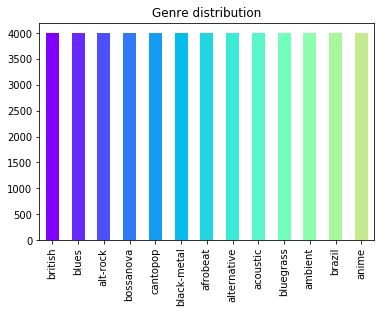

In [3]:
colors=iter(plt.cm.rainbow(np.linspace(0,1,20)))

spotify_data['Genre'].value_counts().plot(kind='bar', title='Genre distribution', color=colors)

#### Labels
In this case, we have **13 genres**, all with almost the same distribution (around 4000 each). Now let's encode the labels, split the data into train and test sets and scale them. I chose Robust Scaler because the attributes not only have different distributions, but also many outliers and Robust Scaler perfoms better with this kind of data.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler

le = LabelEncoder()
spotify_data.loc[:, 'Genre'] = le.fit_transform(spotify_data.loc[:, 'Genre'])

X, Y = spotify_data.drop('Genre', axis=1).values, spotify_data.loc[:, 'Genre'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

##### Now we can get to comparing classifiers.
For this project I chose: K-nearest neighbours, SVM, decision tree, random forest, AdaBoost and Naive Bayes. I didn't choose neural network, because here I wanted to focus on other algorithms used for classifying and understand them better.

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

dtc = DecisionTreeClassifier(random_state=8)
rfc = RandomForestClassifier(random_state=8, n_jobs=2)
knnc = KNeighborsClassifier(algorithm='auto')
svc = SVC(random_state=8, shrinking=True, probability=True)
abcr = AdaBoostClassifier(random_state=8, algorithm='SAMME.R')
gnb = GaussianNB()
classifiers =[dtc, rfc, knnc, svc, abcr, gnb]

##### First, let's see how each classifier performs without tuning.

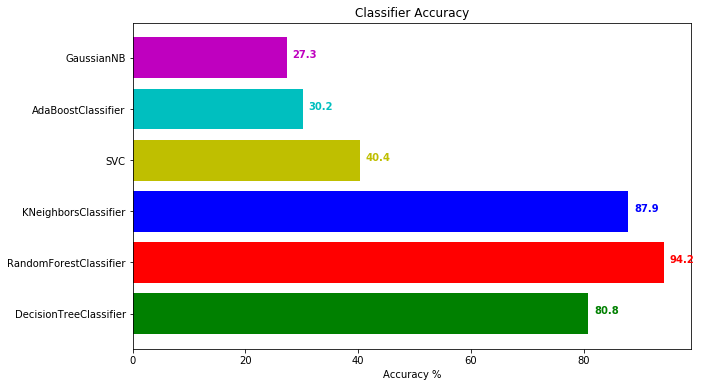

,Classifier,Accuracy
0,DecisionTreeClassifier,80.837
0,RandomForestClassifier,94.250
0,KNeighborsClassifier,87.885
0,SVC,40.365
0,AdaBoostClassifier,30.154
0,GaussianNB,27.326


In [8]:
cols=['Classifier', 'Accuracy']
results_default = pd.DataFrame(columns=cols)
for clf in classifiers:
    clf.fit(scaled_X_train, Y_train)
    name = clf.__class__.__name__

    train_predictions = clf.predict(scaled_X_test)
    acc = accuracy_score(Y_test, train_predictions)

    results_entry = pd.DataFrame([[name, acc*100]], columns=cols)
    results_default = results_default.append(results_entry)

plt.subplots(figsize=(10,6))
color_table = ['g', 'r','b','y','c','m']
plt.barh(y = results_default.loc[:, 'Classifier'], width=results_default.loc[:, 'Accuracy'], color = color_table)
for i, v in enumerate(results_default.loc[:, 'Accuracy']):
    plt.text(v+1, i , str(round(v,1)), color=color_table[i], fontweight='bold')
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

results_default

##### Now let's create a function to compare parameters and then  we'll specify parameters to lookup in the decision tree.
I'll use GridSearchCV for finding the optimal parameter. Of course there's a posibility the true optimum will fall outside our range, but these should give us a pretty well performing classifier. 

In [9]:
def tune_classifier(parameters_dict, clf, create_plot, rows=2, columns=2):
    # index is for keeping tack of the subplot's position on the figure matrix
    index = 1
    best_parameters = {}
    for parameter, p_range in parameters_dict.items():
        gscv = GridSearchCV(estimator = clf, param_grid = {parameter: p_range}, scoring='accuracy', cv=5, n_jobs = 2)
        gscv.fit(scaled_X_train, Y_train)

        best_parameters.update(gscv.best_params_)
        means = gscv.cv_results_['mean_test_score']
        if create_plot:
            plt.subplot(rows, columns, index)
            plt.xlabel('parameter value')
            plt.ylabel('accuracy')
            plt.plot(p_range, means)
            plt.title(parameter)
            index += 1
        else:
            print("best params: {}".format(gscv.best_params_))

    return best_parameters

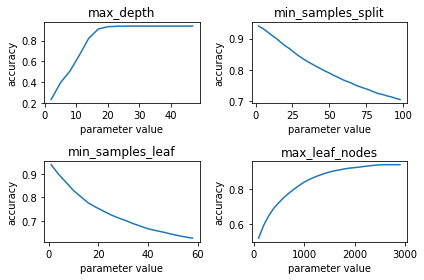

In [10]:
dt_parameters = {
    'max_depth' : list(np.arange(2,50,3)) + [None],
    "min_samples_split": np.arange(2,100,3),
    "min_samples_leaf": np.arange(1,60,3),
    "max_leaf_nodes": list(np.arange(100,3000,100)) + [None]
    }
best_parameters_dt = tune_classifier(dt_parameters, dtc, True)
dtc.set_params(**best_parameters_dt)
plt.tight_layout()
plt.show()


##### Great, now that we found our optimal parameters for DT, let's see how it'll look on other classifiers.

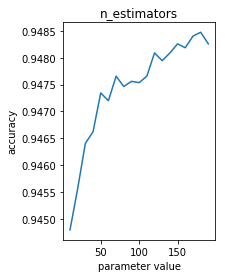

In [12]:
rf_parameters = {
    'n_estimators' : np.arange(10, 200, 10)
    }
best_parameters_rf = tune_classifier(rf_parameters, rfc, True, 1, 2)
best_parameters_rf.update(best_parameters_dt)
rfc.set_params(**best_parameters_rf)

plt.show()

In [13]:
knn_parameters = {
    'n_neighbors': np.arange(2,15,2),
    'leaf_size' : np.arange(10,150, 20), 
    'p' : np.arange(1,3,1),
    }
best_parameters_knn = tune_classifier(knn_parameters, knnc, False)

best params: {'n_neighbors': 2}
best params: {'leaf_size': 70}
best params: {'p': 2}


KNeighborsClassifier(algorithm='auto', leaf_size=70, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [14]:
svc_parameters = {
    'C' : [1, 100, 1000],
    'kernel' : ['rbf', 'sigmoid','linear'],
    'degree' : [1,2,3],
    'gamma' : [0.01, 0.1 ,1, 'auto']
    }
best_parameters_svc = tune_classifier(svc_parameters, svc, False)
svc.set_params(**best_parameters_svc)

best params: {'gamma': 1}
best params: {'kernel': 'rbf'}
best params: {'C': 1}
best params: {'degree': 1}


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
  verbose=False)

In [15]:
abcr_parameters = {
    'base_estimator' : [None, dtc, rfc],
    'n_estimators' : np.arange(2,100,2),
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
    }
best_parameters_abcr = tune_classifier(abcr_parameters, abcr, False)
abcr.set_params(**best_parameters_abcr)

best params: {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=29,
max_features=None, max_leaf_nodes=None,
min_impurity_decrease=0.0, min_impurity_split=None,
min_samples_leaf=1, min_samples_split=2,
min_weight_fraction_leaf=0.0, presort=False, random_state=8,
splitter='best')}
best params: {'n_estimators': 40}
best params: {'learning_rate': 1}


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=29,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8,
            splitter='best'),
          learning_rate=1, n_estimators=40, random_state=8)

##### We found best parameters for each classifier, so now let's see how they compare to one another.

In [16]:
cols=['Classifier', 'Accuracy', 'Log Loss']
results = pd.DataFrame(columns=cols)

for clf in classifiers:
    clf.fit(scaled_X_train, Y_train)
    name = clf.__class__.__name__

    train_predictions = clf.predict(scaled_X_test)
    acc = accuracy_score(Y_test, train_predictions)

    train_predictions = clf.predict_proba(scaled_X_test)
    ll = log_loss(Y_test, train_predictions)

    results_entry = pd.DataFrame([[name, acc*100, ll]], columns=cols)
    results = results.append(results_entry)

##### Now we can graph the performance of all the models. Below is the Accuracy measure of each classifier and Log Loss.

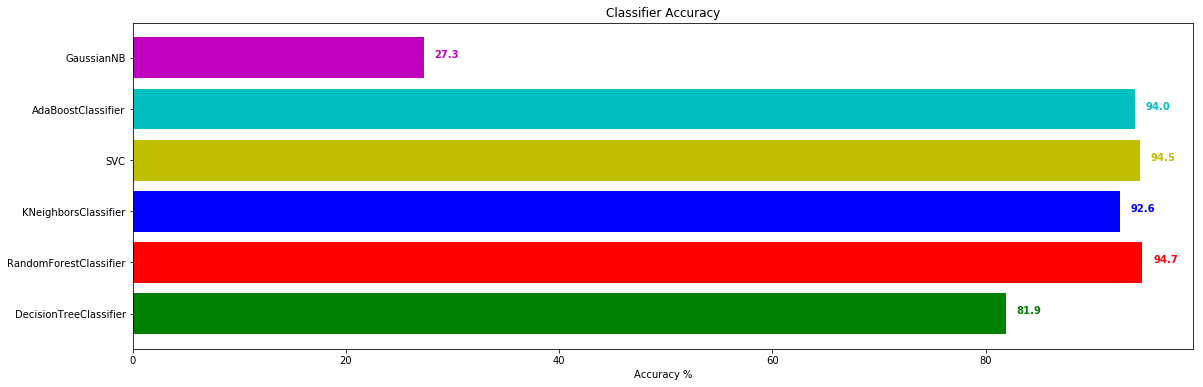

In [18]:
plt.subplots(figsize=(19,6))
plt.barh(y = results.loc[:, 'Classifier'], width=results.loc[:, 'Accuracy'], color = color_table)
for i, v in enumerate(results.loc[:, 'Accuracy']):
    plt.text(v+1, i , str(round(v,1)), color=color_table[i], fontweight='bold')
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

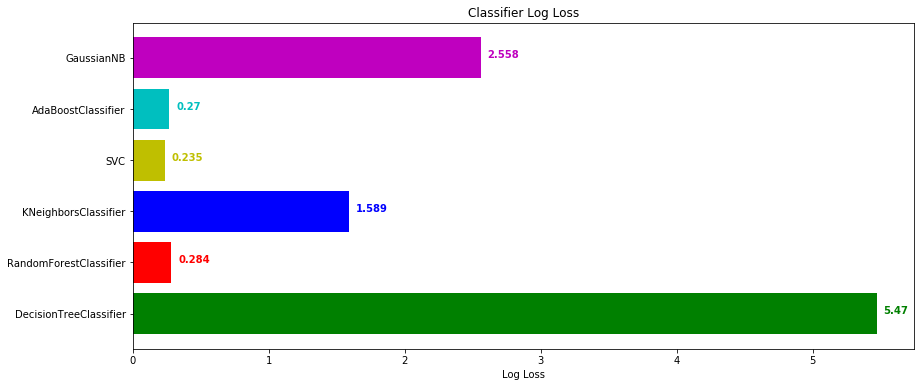

In [19]:
plt.subplots(figsize=(14,6))
plt.barh(y = results.loc[:, 'Classifier'], width=results.loc[:, 'Log Loss'], color = color_table)
for i, v in enumerate(results.loc[:, 'Log Loss']):
    plt.text(v+0.05,i , str(round(v,3)), color=color_table[i], fontweight='bold')
plt.xlabel('Accuracy %')
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

##### We can see the SVM with RBF kernel achieved the lowest log loss and Random Forest had the highest accuracy, but the two weren't that far from each other. AdaBoost with Decision Tree is also right behind them in both scores.
Bayes achieved the worst accuracy score and Decision Tree had very high log loss score.

All in all, I think this project was quite interesting. Recognising musical genres is hard even for humans, so to achieve a 94.7% accuracy score in the sample is a success. Besides, I've also managed to learn quite a lot about these classifiers, working in scikit-learn and writing REST scripts.
I'm definitely going to continue this project in the future and try to implement a neural network with TensorFlow.